In [1]:
import pandas as pd

train_df = pd.read_csv('./data/toxic_train.csv')
test_df = pd.read_csv('./data/toxic_test.csv')

In [2]:
train_df = train_df.drop(columns=['Unnamed: 0'])
train_df

,comment_text,toxic
0,Explanation\r\nWhy the edits made under my use...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \r\n\r\nThat...,0
159568,"Spitzer \r\n\r\nUmm, theres no actual article ...",0
159569,And it looks like it was actually you who put ...,0


In [3]:
test_df = test_df.drop(columns=['Unnamed: 0'])
test_df

,comment_text,toxic
0,Thank you for understanding. I think very high...,0
1,:Dear god this site is horrible.,0
2,"""::: Somebody will invariably try to add Relig...",0
3,""" \r\n\r\n It says it right there that it IS a...",0
4,""" \r\n\r\n == Before adding a new product to t...",0
...,...,...
63973,":Jerome, I see you never got around to this…! ...",0
63974,==Lucky bastard== \r\n http://wikimediafoundat...,0
63975,==shame on you all!!!== \r\n\r\n You want to s...,0
63976,MEL GIBSON IS A NAZI BITCH WHO MAKES SHITTY MO...,1


## Preprocessing

In [143]:
# selecting text data

train_df = train_df.sample(frac=1) #shuffling the training dataset
train = train_df['comment_text']
train = train.to_list()
train

['"\r\nThe guy is a liar and actively promotes lying if it serves his agenda (as explicitly stated in Earthforce).\r\n""Since the statement is wrong..."" Which statement? If it is Paul\'s, then yes, we know. If it is the Gazette\'s then where? This is a RS too. \xa0talk "',
 'Support as primary for this formatting (with plus signs).',
 'Kent Williams still considers himself to be a republican. And to user Q, Where are you from?',
 '21 and 23 SAS are not part of the SAS as if they want to join 22SAS they need to do selection.',
 "doesn't seem very useful",
 'How are you supposed to have a discussion on editing when you can not explain your rational? All I am doing is taking these ignoramuses down the path of logic, it seems like I have to hold their hands and show them the light.\r\n\r\nIt seems like the more my posts become real and truthful, the more wiki janitors come out of the closet to censor it.',
 'I will kill you \r\n\r\ni will blow up your house and kill your family one by one

### Creating a transformer for preprocessing text data

In [144]:
from sklearn.base import BaseEstimator, TransformerMixin

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize

import re

# transformer class
class TextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, stopwords, stemmer):
        super().__init__()
        self.stopwords = stopwords
        self.stemmer = stemmer
        self.hapaxes = []
        self.named_entities = []
    
    # by default a transformer's fit method just returns self
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for i, sample in enumerate(X):
            X[i] = self.__normalize(sample)
            X[i] = self.__eliminate_stopwords(X[i])
            X[i] = self.__get_hapaxes(X[i])
            X[i] = self.__stem(X[i])
            self.__named_entity_extraction(X[i])
        
        return X

    def __normalize(self, text):
        return ' '.join(re.findall('[a-zA-Z]+', text.lower().replace(r'\r', ' ').replace(r'\n', ' ')))
    
    def __eliminate_stopwords(self, text):
        if self.stopwords is not None:
            return ''.join([word for word in text if word not in self.stopwords])
    
    def __get_hapaxes(self, text, eliminate=True):
        fd = FreqDist(word_tokenize(text))
        self.hapaxes.append(fd.hapaxes())
                       
        if eliminate:
            text = ''.join([word for word in text if word not in self.hapaxes])
        
        return text
    
    def __stem(self, text):
        return ' '.join([self.stemmer.stem(word) for word in word_tokenize(text)])
    
    def __named_entity_extraction(self, text):
        for sent in sent_tokenize(text):
            for chunk in nltk.ne_chunk(nltk.pos_tag(word_tokenize(sent))):
                if hasattr(chunk, 'label'):
                    self.named_entities.append(chunk)

### Using the transformer to preprocess the training text

In [145]:
from nltk.stem import PorterStemmer

transformer = TextTransformer(stopwords=['and', 'for', 'in', 'about', 'for', 'as', 'the'], stemmer=PorterStemmer())

In [146]:
train = transformer.transform(train[:1024])
train

['the guy is a liar and activ promot lie if it serv hi agenda as explicitli state in earthforc sinc the statement is wrong which statement if it is paul s then ye we know if it is the gazett s then where thi is a rs too talk',
 'support as primari for thi format with plu sign',
 'kent william still consid himself to be a republican and to user q where are you from',
 'and sa are not part of the sa as if they want to join sa they need to do select',
 'doesn t seem veri use',
 'how are you suppos to have a discuss on edit when you can not explain your ration all i am do is take these ignoramus down the path of logic it seem like i have to hold their hand and show them the light it seem like the more my post becom real and truth the more wiki janitor come out of the closet to censor it',
 'i will kill you i will blow up your hous and kill your famili one by one slowli and pain',
 'john lloyd scharf i have repeatedli warn victar ma not to includ data from person research and make addit tha

## Choosing the model

The plan is to test the accuracy of different models on the same dataset.

In [147]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix


### The training dataset

In [148]:
X = pd.DataFrame(train, columns=['text']).dropna()['text'].values
y = train_df[:1024]['toxic'].dropna().values
X, y

(array(['the guy is a liar and activ promot lie if it serv hi agenda as explicitli state in earthforc sinc the statement is wrong which statement if it is paul s then ye we know if it is the gazett s then where thi is a rs too talk',
        'support as primari for thi format with plu sign',
        'kent william still consid himself to be a republican and to user q where are you from',
        ...,
        'idiot you re an idiot i just realiz that when you block me you said it wa becaus i wa use my ip address as a sockpuppet to avoid a block obvious the way i wa edit page and attack peopl show that i didn t care if i wa block if i left ani comment on your page as anyth but emokid it s becaus occasion the websit will sign me off when i go to a differ page also just curiou when that block end anyway',
        'common name are not capit just want to remind peopl that fish common name are not capit with a few except it s neon tetra not neon tetra see the guidelin of common name and scient

In [149]:
X.shape, y.shape

((1024,), (1024,))

### The testing dataset

In [150]:
X_test = test_df[:1024]['comment_text'].values
y_test = test_df[:1024]['toxic'].values
X_test, y_test

(array(['Thank you for understanding. I think very highly of you and would not revert without discussion.',
        ':Dear god this site is horrible.',
        '"::: Somebody will invariably try to add Religion?  Really??  You mean, the way people have invariably kept adding ""Religion"" to the Samuel Beckett infobox?  And why do you bother bringing up the long-dead completely non-existent ""Influences"" issue?  You\'re just flailing, making up crap on the fly. \r\n ::: For comparison, the only explicit acknowledgement in the entire Amos Oz article that he is personally Jewish is in the categories!    \r\n\r\n "',
        ...,
        '", 26 July 2010 (UTC) \r\n ::Can they be pink with blue spots?  Joking aside I don\'t think we can and it should probably stop.  Off2rio has taken this position on right wing articles for some time, generally against consensus.  Ditto on some of the British Isles disputes.  My original point (which I have probably repeated for too long) is that we have t

### Logistic Regression

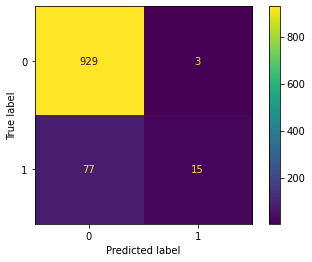

In [173]:
from sklearn.linear_model import LogisticRegression

lr_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    LogisticRegression()
)

lr_pipe.fit(X, y)
plot_confusion_matrix(lr_pipe, X_test, y_test)

### NB models

Complement Naive Bayes
Bernoulli Naive Bayes
Multinomial Naive Bayes


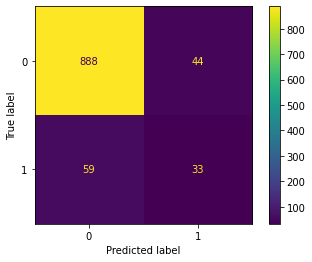

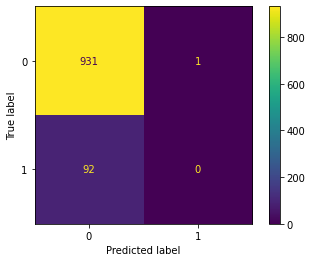

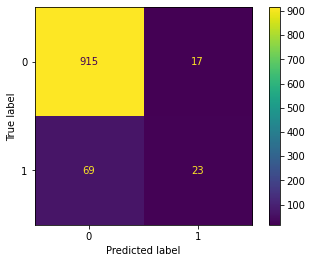

In [178]:
from sklearn.naive_bayes import ComplementNB, BernoulliNB, MultinomialNB

cnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    ComplementNB()
)

bnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    BernoulliNB()
)

mnb_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    MultinomialNB()
)

# fitting the models
cnb_pipe.fit(X, y)
print('Complement Naive Bayes')
plot_confusion_matrix(cnb_pipe, X_test, y_test)

bnb_pipe.fit(X, y)
print('Bernoulli Naive Bayes')
plot_confusion_matrix(bnb_pipe, X_test, y_test)

mnb_pipe.fit(X, y)
print('Multinomial Naive Bayes')
plot_confusion_matrix(mnb_pipe, X_test, y_test)

### Decision Tree

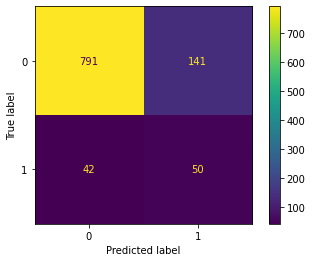

In [179]:
from sklearn.tree import DecisionTreeClassifier

dt_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    DecisionTreeClassifier()
)

dt_pipe.fit(X, y)
plot_confusion_matrix(dt_pipe, X_test, y_test)

### K-nearest neighbors

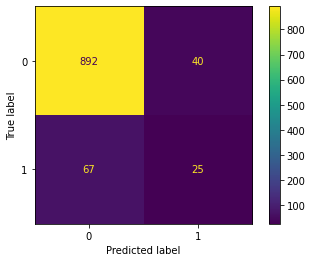

In [180]:
from sklearn.neighbors import KNeighborsClassifier

kn_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    KNeighborsClassifier()
)

kn_pipe.fit(X, y)
plot_confusion_matrix(kn_pipe, X_test, y_test)

### Perceptron

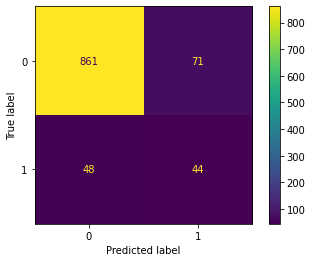

In [181]:
from sklearn.linear_model import Perceptron

p_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    Perceptron()
)

p_pipe.fit(X, y)
plot_confusion_matrix(p_pipe, X_test, y_test)

### Support Vector Machine

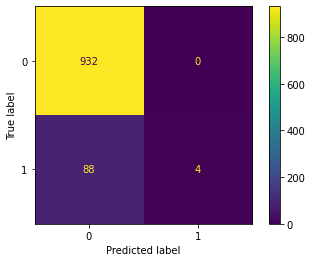

In [182]:
from sklearn.svm import SVC

svm_pipe = make_pipeline(
    TfidfVectorizer(),
    MaxAbsScaler(),
    SVC()
)

svm_pipe.fit(X, y)
plot_confusion_matrix(svm_pipe, X_test, y_test)

## Comparing accuracy scores

In [186]:
scores = {
    'Logistic Regression': [accuracy_score(y_test, lr_pipe.predict(X_test))],
    'Complement NB': [accuracy_score(y_test, cnb_pipe.predict(X_test))],
    'Bernoulli NB': [accuracy_score(y_test, bnb_pipe.predict(X_test))],
    'Multinomail Regression': [accuracy_score(y_test, mnb_pipe.predict(X_test))],
    'K-nearest neighbors': [accuracy_score(y_test, kn_pipe.predict(X_test))],
    'Perceptron': [accuracy_score(y_test, p_pipe.predict(X_test))],
    'SVM': [accuracy_score(y_test, svm_pipe.predict(X_test))]
}

scores_df = pd.DataFrame.from_dict(scores)
scores_df

,Logistic Regression,Complement NB,Bernoulli NB,Multinomail Regression,K-nearest neighbors,Perceptron,SVM
0,0.921875,0.899414,0.90918,0.916016,0.895508,0.883789,0.914062


In [212]:
# the best accuracy
model_name = scores_df.idxmax(axis=1)[0]
f'{model_name} : {scores_df[model_name][0]}'

'Logistic Regression : 0.921875'